In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *

In [2]:
NUM_SAMPLES_PER_CLASS = 2000
NUM_VAL = 50 * 400

In [3]:
PATH = Path('data/txt')

In [5]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10200/106879/test_simplified.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1543038357&Signature=mCJep59MUYfkxdjh53%2FPu69W%2BFjX38ZV5mQvgw0xGsQiTs0Cm7po4Q5qyy1W4R2%2BByWzVGARiH6pQbaowXbBrj1OgvJzGpFtSZQ5x2xG3Q2f3165QjAa0Tgs8BcIQ3kdSFgQrApK1xwni0kFOf59ZDOR34KM18BMvWgTeSbjexJp5tLhGoDfJ3yLWbGvQhW1py9Ks0InfC0Kh87V%2FnX90TxJCgjN8G5Cs6YqVqJJgUKQ3pKZ3oqDZV2JfyPNHG2XYV8PMwS2nff9I3VqM%2FywHx5K4msbtzLH6YvLiNsoZ%2FwQtLnmgN8YGisjW1wEjFLuJEBgrV43%2FlSQaTkKmqwPFA%3D%3D' --output 'test_simplified.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.9M  100 58.9M    0     0  97.1M      0 --:--:-- --:--:-- --:--:-- 97.1M


In [6]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10200/106879/train_simplified.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1543038596&Signature=ijxlYIgcF8%2BGtF9HKF5yjwPU2hoGPG%2FCM4si6vw5NDlunrUI2gjsqq1Z8O4S0EfV9GYK5BmX6%2FlGA08gQ1s2Poux9donsSBkao%2FDTwGNdLYdBygB87PIdFLncXsJvtYoTCG2kIyJd%2B4QdKKWGxIzANRYylKY%2FVvmo0exUZDkwcXR2vUDwwtd0KNw7quNU3tkoXs2VUsI%2BOJ0OHtNv5HefE9TIQLG64JXCvkSk0wfVuPr5s7QA2BgV4dYpvws2tZADJ6XQl%2FxNwOBR%2Fta90fgnxuKnblh%2FU8%2F9aU7RTDJObV2KQ4CSkH5BptCOYbtqqKtgJ0ropNRmgm6fcq87OU1PQ%3D%3D' --output 'train_simplified.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7550M  100 7550M    0     0  52.4M      0  0:02:23  0:02:23 --:--:--  103M


### Generate data from csvs

In [4]:
PATH.mkdir(exist_ok=True)
(PATH/'train').mkdir(exist_ok=True)
(PATH/'test').mkdir(exist_ok=True)

In [5]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (PATH/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(min(NUM_SAMPLES_PER_CLASS,df.shape[0])).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(PATH/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)
    del df
            
def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(PATH/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)
    del df

In [8]:
%time create_test_txts_from_df('data/test_simplified.csv')

CPU times: user 33.3 s, sys: 3.6 s, total: 36.9 s
Wall time: 37.5 s


In [11]:
%time for p in Path('data/train').iterdir(): create_train_txts_from_df(p)

CPU times: user 7min 40s, sys: 42.5 s, total: 8min 23s
Wall time: 9min 58s


###  Create ImageDataBunch using the data block API

In [6]:
sz = 128
bs = 740

In [7]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [8]:
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)

In [9]:
item_list

ItemList (680000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train

In [10]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]

In [11]:
item_lists = item_list.split_by_idx(val_idxs)

In [10]:
item_lists

ItemLists;
Train: ItemList (660000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train;
Valid: ItemList (20000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train;
Test: None

In [12]:
label_lists = item_lists.label_from_folder()
pd.to_pickle(label_lists.train.y.classes, 'data/classes.pkl')

In [13]:
classes = pd.read_pickle('data/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);

In [14]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=24)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=24)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=24)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [15]:
pd.to_pickle(data_bunch.batch_stats(), f'data/batch_stats_{sz}.pkl')

In [16]:
batch_stats = pd.read_pickle(f'data/batch_stats_{sz}.pkl')

In [17]:
data_bunch.normalize(batch_stats);

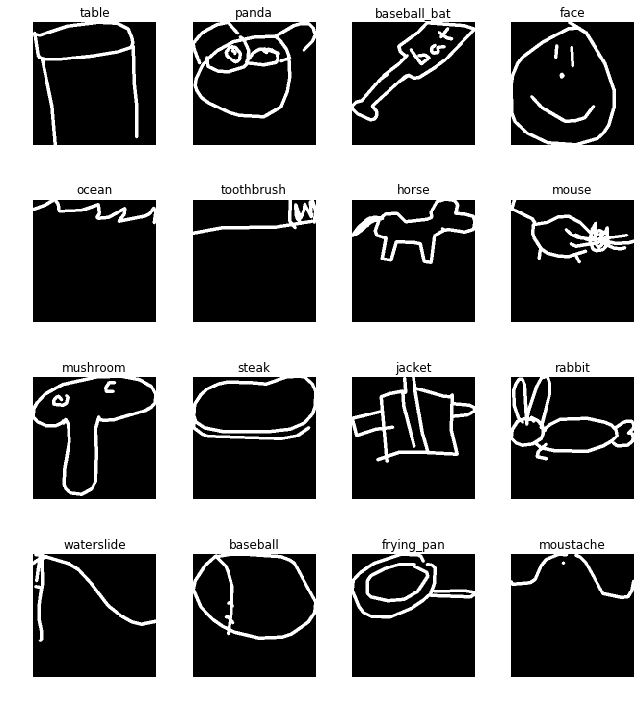

In [20]:
data_bunch.show_batch(rows=4)

### Train

In [18]:
name = f'res34-{sz}'

In [19]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [27]:
torch.cuda.device_count()

2

In [20]:
learn.model = nn.DataParallel(learn.model)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


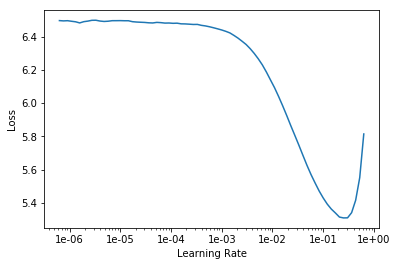

In [30]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2,4e-2)

Total time: 21:37
epoch  train_loss  valid_loss  accuracy  map3    
1      1.913718    1.684851    0.576850  0.670250  (13:34)
2      1.428472    1.218923    0.691500  0.768200  (08:03)



In [24]:
learn.save(f'{name}-stage-1')

In [ ]:
learn.load(f'{name}-stage-1')

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


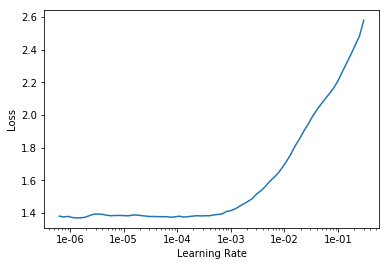

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(6, slice(3e-5,3e-4))

Total time: 1:03:57
epoch  train_loss  valid_loss  accuracy  map3    
1      1.321674    1.157359    0.708400  0.781875  (10:32)
2      1.245822    1.111948    0.717500  0.790200  (10:35)
3      1.134521    1.054832    0.731300  0.802625  (10:33)
4      1.041131    1.011929    0.740750  0.810617  (10:42)
5      0.946481    0.986680    0.748150  0.816975  (10:43)
6      0.887884    0.983119    0.749850  0.817542  (10:49)



In [ ]:
learn.save(f'{name}-stage-2')

In [ ]:
learn.fit_one_cycle(2, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,map3


In [31]:
learn.save(f'{name}-stage-3')

In [32]:
learn.fit_one_cycle(2, slice(1e-5,1e-4))

Total time: 21:13
epoch  train_loss  valid_loss  accuracy  map3    
1      0.877945    0.999036    0.747650  0.816000  (10:39)
2      0.818139    0.990726    0.752600  0.819292  (10:34)



In [33]:
learn.save(f'{name}-stage-4')

### Predict

In [34]:
learn.load(f'{name}-stage-4');

In [35]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [37]:
!mkdir -p ./subs

In [38]:
create_submission(preds, data_bunch.test_dl, name, classes)

In [39]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9652253642497819,broccoli tree camouflage
1,9315520565050012,penguin parrot kangaroo
2,9863984627431153,horse barn dog
3,9114174502557042,camera toaster backpack
4,9307433665850983,dishwasher oven stove


In [42]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|███████████████████████████████████████| 1.53M/1.53M [00:01<00:00, 837kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

In [40]:
from IPython.display import FileLink

In [41]:
FileLink('./subs/res34-128.csv.gz')

/ext/quickdraw/subs/res34-128.csv.gz